###  Predict Iowa House Prices using Regression

In [1]:
#"Premature optimization is the root of all evil.." -Donald Knuth
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

pd.options.display.max_rows=350
pd.options.display.max_columns=350

#Models for parameter selection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#Models for prediction
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge #BEST LEARNER

In [2]:
#Pipeline and transformation functions

#transformers
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

#ColumnTransformer applies different transformers to different columns
from sklearn.compose import ColumnTransformer

#sequentially applies listed transformers and a final estimator
from sklearn.pipeline import Pipeline

import time
start1 = time.time()

In [3]:
#Fetch data
train1=pd.read_csv('data/train.csv')
test1=pd.read_csv('data/test.csv')
train=train1.copy()
test=test1.copy()

In [4]:
train['YrSold'].value_counts()

2009    338
2007    329
2006    314
2008    304
2010    175
Name: YrSold, dtype: int64

In [5]:
print('train:')
train.head(3)

train:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [6]:
from scipy import stats
from scipy.stats import norm
from scipy.stats import yeojohnson  #input must be float64

def normalize_feature(df, bad_feature):

    #Make histogram & normal probability plot
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,3),constrained_layout=True)
    sns.distplot(df[bad_feature], color='r', fit=stats.norm, ax=ax1)
    ax1.set_title(f'{bad_feature} Histogram - Not Normal Distribution')
    res=stats.probplot(df[bad_feature], dist='norm', plot=ax2)
    ax2.set_title('Fit to Normal Distribution')

    #Normalize with log (x+1).  Log of skewed feature: log e(feature+1)=normFeat
    #Exponential equation to undo normpr: e^normFeat-1=feature
    log_feat=np.log(df[bad_feature]+1)
    lamYJ = 2            #dummy value for function to return
    #log_feat, lamYJ = yeojohnson(np.array(df[bad_feature]))
        
    #Plots after normalization
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,3),constrained_layout=True)
    sns.distplot(log_feat, color='g', fit=norm, ax=ax1)
    ax1.set_title(bad_feature+' Histogram - Normal Distribution')
    res=stats.probplot(log_feat, dist='norm', plot=ax2)
    ax2.set_title('Fit to Normal Distribution')
    return log_feat, lamYJ

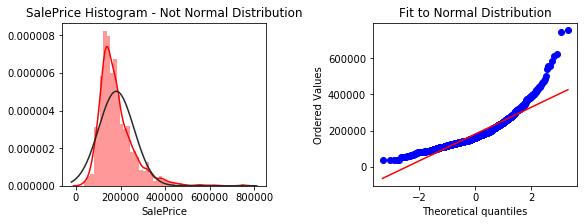

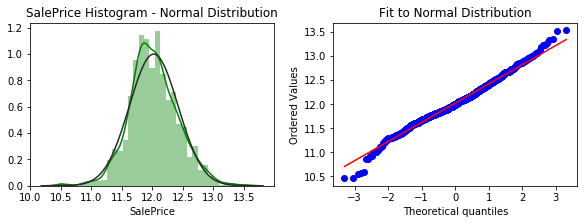

In [7]:
#Normalize SalePrice.  Johnson transform must be float64. lamYJ required so tranform can be undone.
#train['SalePrice']=train['SalePrice'].astype('float64')
train['SalePrice'], lamYJ = normalize_feature(df=train, bad_feature='SalePrice')
#train['SalePrice'], lamYJ = normalize_feature(df=train, bad_feature='SalePrice')

In [8]:
#COMBINE train/test for cleaning.  A data issue can be unique to one csv, like a different class type for a feature.
#train Id: 1-1460.  test Id: 1461-2919.
comb=train.append(test, ignore_index=True, sort=False).copy()  #Id identifies the observation rows
print('Orig comb shape:', comb.shape)

Orig comb shape: (2919, 81)


In [9]:
print('comb:')
comb.tail(3)

comb:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
2916,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
2917,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,912.0,GasA,TA,Y,SBrkr,970,0,0,970,0.0,1.0,1,0,3,1,TA,6,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,80,32,0,0,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN
2918,2919,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,2Story,7,5,1993,1994,Gable,CompShg,HdBoard,HdBoard,BrkFace,94.0,TA,TA,PConc,Gd,TA,Av,LwQ,758.0,Unf,0.0,238.0,996.0,GasA,Ex,Y,SBrkr,996,1004,0,2000,0.0,0.0,2,1,3,1,TA,9,Typ,1,TA,Attchd,1993.0,Fin,3.0,650.0,TA,TA,Y,190,48,0,0,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal,NaN


### Data Cleaning

In [10]:
#Replace feature nans.  MSZoning fixed separately.
nan_dict={
            'Alley' : {np.nan : 'None'},
            'BsmtCond' : {np.nan : 'None'},
            'BsmtExposure' : {np.nan : 'None'},
            'BsmtFinSF1' : {np.nan : 0},
            'BsmtFinSF2' : {np.nan : 0},
            'BsmtFinType1' : {np.nan : 'None'},
            'BsmtFinType2' : {np.nan : 'None'},
            'BsmtFullBath' : {np.nan : 0},
            'BsmtHalfBath' : {np.nan : 0},
            'BsmtQual' : {np.nan : 'None'},
            'BsmtUnfSF' : {np.nan : 0},
            'Electrical' : {np.nan : 'SBrkr'},
            'Exterior1st' : {np.nan : 'VinylSd'},
            'Exterior2nd' : {np.nan : 'VinylSd'},
            'Fence' : {np.nan : 'None'},
            'FireplaceQu' : {np.nan : 'None'},
            'Functional' : {np.nan : 'Typ'},
            'GarageArea' : {np.nan : 0},
            'GarageCars' : {np.nan : 0},               #If omitted, probably zero.
            'GarageCond' : {np.nan : 'None'},
            'GarageFinish' : {np.nan : 'None'},
            'GarageQual' : {np.nan : 'None'},
            'GarageType' : {np.nan : 'None'},
            'KitchenQual' : {np.nan : 'TA'},
            'MasVnrArea' : {np.nan : 0},
            'MasVnrType' : {np.nan : 'None'},
            'MiscFeature' : {np.nan : 'None'},
            'PoolQC' : {np.nan : 'None'},
            'SaleType' : {np.nan : 'WD'},
            'TotalBsmtSF' : {np.nan : 0},
            'Utilities' : {np.nan : 'AllPub'}
        }

comb.replace(nan_dict, inplace=True)

In [11]:
comb.BsmtCond.value_counts(dropna=False)

TA      2606
Gd       122
Fa       104
None      82
Po         5
Name: BsmtCond, dtype: int64

In [12]:
#Inverse Yeo Yohnson transformation.  Possible alternative to natural log.
def reverse_yj_tranform(y, lam):
    '''
    Undo Yeo Johnson transform.  x was transformed to y.  Handles
    x >= 0 scenarios only.  x<0 must be derived.
    '''
    if lam != 0:   #for x >= 0 and lam != 0 case
        pwr=np.log((lam*y+1))/lam        
        return np.exp(pwr)
    elif lam == 0:   #for x >= 0 and lam = 0 case
        return np.exp(y) - 1

In [13]:
def custom_imputer(train_df, repl_df, cat_col, stati_col, stati_string, repl_on=False):
    '''
    View stati_col stat (Ex. 'mean') aggregated by each category in the 
    cat_col. Stats are based on train.  Use ONLY train to avoid leakage.
    Optionally, replace NaNs in the stati_col by setting repl_on = True.
    repl_df is the dataframe where NaNs will be replaced.
    '''
    repl_df1=repl_df.copy()   #work on copy so original dataframe is untouched
    stat_dict={}
    categories = sorted(train_df[cat_col].dropna().unique())
    for category in categories:   #get the stat value for each category key        
        if stati_string == 'mean':
            cat_train_df = train_df[train_df[cat_col] == category]
            stat_dict[category] = cat_train_df[stati_col].mean(skipna=True)            
        elif stati_string == 'median':
            cat_train_df = train_df[train_df[cat_col] == category]
            stat_dict[category] = cat_train_df[stati_col].median(skipna=True)
        elif stati_string == 'mode':
            cat_train_df = train_df[train_df[cat_col] == category]
            try:
                stat_dict[category] = cat_train_df[stati_col].mode(dropna=True)[0]
            except:
                print(f'{stati_col} in {category} likely NaN, causing indexing error. Set stat_dict val to np.nan.')
                stat_dict[category] = np.nan
        else:
            print("Invalid stati_string.  Must use 'mean', 'median', or 'mode'.")          
    
    print(f"stat_dict format - '{cat_col}' : {stati_col} '{stati_string}'"), print('--------------------------------------------') 
    print(stat_dict)
    print(f'\n### repl_df BEFORE ###: "{stati_col}" NaNs:')
    display(repl_df1[repl_df1[stati_col].isna()])

    indices_of_replaced=repl_df1[repl_df1[stati_col].isna()].index  #record indices of NaN rows   
    if repl_on == True:
        #fill category NaN with stat from stat_dict.
        for category in categories:
            repl_df1.loc[repl_df1[cat_col] == category, stati_col]=\
            repl_df1.loc[repl_df1[cat_col] == category, stati_col].fillna(stat_dict[category])
        #show repl_df1 replacement values that were formerly NaN    
        print(f'\n### repl_df AFTER ###: "{stati_col}" NaNs filled per stat_dict:')
        display(repl_df1.iloc[indices_of_replaced])
    return repl_df1

In [14]:
#Replace MSZoning NaNs with MSZoning mode by Neighborhood.  Save result to 'comb'.
comb=custom_imputer(train_df=train, repl_df=comb, cat_col='Neighborhood', stati_col='MSZoning',
                         stati_string='mode', repl_on=True)

stat_dict format - 'Neighborhood' : MSZoning 'mode'
--------------------------------------------
{'Blmngtn': 'RL', 'Blueste': 'RM', 'BrDale': 'RM', 'BrkSide': 'RM', 'ClearCr': 'RL', 'CollgCr': 'RL', 'Crawfor': 'RL', 'Edwards': 'RL', 'Gilbert': 'RL', 'IDOTRR': 'RM', 'MeadowV': 'RM', 'Mitchel': 'RL', 'NAmes': 'RL', 'NPkVill': 'RL', 'NWAmes': 'RL', 'NoRidge': 'RL', 'NridgHt': 'RL', 'OldTown': 'RM', 'SWISU': 'RL', 'Sawyer': 'RL', 'SawyerW': 'RL', 'Somerst': 'FV', 'StoneBr': 'RL', 'Timber': 'RL', 'Veenker': 'RL'}

### repl_df BEFORE ###: "MSZoning" NaNs:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1915,1916,30,NaN,109.0,21780,Grvl,None,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,2,4,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,Fa,CBlock,None,None,None,None,0.0,None,0.0,0.0,0.0,GasA,TA,N,FuseA,810,0,0,810,0.0,0.0,1,0,1,1,TA,4,Min1,0,None,Detchd,1975.0,Unf,1.0,280.0,TA,TA,N,119,24,0,0,0,0,None,None,None,0,3,2009,ConLD,Normal,NaN
2216,2217,20,NaN,80.0,14584,Pave,None,Reg,Low,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1Story,1,5,1952,1952,Gable,CompShg,AsbShng,VinylSd,None,0.0,Fa,Po,Slab,None,None,None,None,0.0,None,0.0,0.0,0.0,Wall,Po,N,FuseA,733,0,0,733,0.0,0.0,1,0,2,1,Fa,4,Typ,0,None,Attchd,1952.0,Unf,2.0,487.0,Fa,Po,N,0,0,0,0,0,0,None,None,None,0,2,2008,WD,Abnorml,NaN
2250,2251,70,NaN,NaN,56600,Pave,None,IR1,Low,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2.5Unf,5,1,1900,1950,Hip,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,686.0,686.0,GasA,Ex,Y,SBrkr,1150,686,0,1836,0.0,0.0,2,0,4,1,TA,7,Maj1,0,None,Detchd,1900.0,Unf,1.0,288.0,TA,Fa,N,0,0,0,0,0,0,None,None,None,0,1,2008,WD,Normal,NaN
2904,2905,20,NaN,125.0,31250,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Artery,Norm,1Fam,1Story,1,3,1951,1951,Gable,CompShg,CBlock,VinylSd,None,0.0,TA,Fa,CBlock,None,None,None,None,0.0,None,0.0,0.0,0.0,GasA,TA,Y,FuseA,1600,0,0,1600,0.0,0.0,1,1,3,1,TA,6,Mod,0,None,Attchd,1951.0,Unf,1.0,270.0,Fa,TA,N,0,0,135,0,0,0,None,None,None,0,5,2006,WD,Normal,NaN



### repl_df AFTER ###: "MSZoning" NaNs filled per stat_dict:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1915,1916,30,RM,109.0,21780,Grvl,None,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,2,4,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,Fa,CBlock,None,None,None,None,0.0,None,0.0,0.0,0.0,GasA,TA,N,FuseA,810,0,0,810,0.0,0.0,1,0,1,1,TA,4,Min1,0,None,Detchd,1975.0,Unf,1.0,280.0,TA,TA,N,119,24,0,0,0,0,None,None,None,0,3,2009,ConLD,Normal,NaN
2216,2217,20,RM,80.0,14584,Pave,None,Reg,Low,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1Story,1,5,1952,1952,Gable,CompShg,AsbShng,VinylSd,None,0.0,Fa,Po,Slab,None,None,None,None,0.0,None,0.0,0.0,0.0,Wall,Po,N,FuseA,733,0,0,733,0.0,0.0,1,0,2,1,Fa,4,Typ,0,None,Attchd,1952.0,Unf,2.0,487.0,Fa,Po,N,0,0,0,0,0,0,None,None,None,0,2,2008,WD,Abnorml,NaN
2250,2251,70,RM,NaN,56600,Pave,None,IR1,Low,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2.5Unf,5,1,1900,1950,Hip,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,686.0,686.0,GasA,Ex,Y,SBrkr,1150,686,0,1836,0.0,0.0,2,0,4,1,TA,7,Maj1,0,None,Detchd,1900.0,Unf,1.0,288.0,TA,Fa,N,0,0,0,0,0,0,None,None,None,0,1,2008,WD,Normal,NaN
2904,2905,20,RL,125.0,31250,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Artery,Norm,1Fam,1Story,1,3,1951,1951,Gable,CompShg,CBlock,VinylSd,None,0.0,TA,Fa,CBlock,None,None,None,None,0.0,None,0.0,0.0,0.0,GasA,TA,Y,FuseA,1600,0,0,1600,0.0,0.0,1,1,3,1,TA,6,Mod,0,None,Attchd,1951.0,Unf,1.0,270.0,Fa,TA,N,0,0,135,0,0,0,None,None,None,0,5,2006,WD,Normal,NaN


In [15]:
#Replace LotFrontage NaNs with median by Neighborhood.  Save result to 'comb'.
comb=custom_imputer(train_df=train, repl_df=comb, cat_col='Neighborhood', stati_col='LotFrontage',
                         stati_string='median', repl_on=True)

stat_dict format - 'Neighborhood' : LotFrontage 'median'
--------------------------------------------
{'Blmngtn': 43.0, 'Blueste': 24.0, 'BrDale': 21.0, 'BrkSide': 52.0, 'ClearCr': 80.0, 'CollgCr': 70.0, 'Crawfor': 74.0, 'Edwards': 65.5, 'Gilbert': 65.0, 'IDOTRR': 60.0, 'MeadowV': 21.0, 'Mitchel': 73.0, 'NAmes': 73.0, 'NPkVill': 24.0, 'NWAmes': 80.0, 'NoRidge': 91.0, 'NridgHt': 88.5, 'OldTown': 60.0, 'SWISU': 60.0, 'Sawyer': 71.0, 'SawyerW': 66.5, 'Somerst': 73.5, 'StoneBr': 61.5, 'Timber': 85.0, 'Veenker': 68.0}

### repl_df BEFORE ###: "LotFrontage" NaNs:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859.0,BLQ,32.0,216.0,1107.0,GasA,Ex,Y,SBrkr,1107,983,0,2090,1.0,0.0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2.0,484.0,TA,TA,Y,235,204,228,0,0,0,None,None,Shed,350,11,2009,WD,Normal,12.206078
12,13,20,RL,NaN,12968,Pave,None,IR2,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,6,1962,1962,Hip,CompShg,HdBoard,Plywood,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,737.0,Unf,0.0,175.0,912.0,GasA,TA,Y,SBrkr,912,0,0,912,1.0,0.0,1,0,2,1,TA,4,Typ,0,None,Detchd,1962.0,Unf,1.0,352.0,TA,TA,Y,140,0,0,0,176,0,None,None,None,0,9,2008,WD,Normal,11.877576
14,15,20,RL,NaN,10920,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,MetalSd,MetalSd,BrkFace,212.0,TA,TA,CBlock,TA,TA,No,BLQ,733.0,Unf,0.0,520.0,1253.0,GasA,TA,Y,SBrkr,1253,0,0,1253,1.0,0.0,1,1,2,1,TA,5,Typ,1,Fa,Attchd,1960.0,RFn,1.0,352.0,TA,TA,Y,0,213,176,0,0,0,None,GdWo,None,0,5,2008,WD,Normal,11.964007
16,17,20,RL,NaN,11241,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,7,1970,1970,Gable,CompShg,Wd Sdng,Wd Sdng,BrkFace,180.0,TA,TA,CBlock,TA,TA,No,ALQ,578.0,Unf,0.0,426.0,1004.0,GasA,Ex,Y,SBrkr,1004,0,0,1004,1.0,0.0,1,0,2,1,TA,5,Typ,1,TA,Attchd,1970.0,Fin,2.0,480.0,TA,TA,Y,0,0,0,0,0,0,None,None,Shed,700,3,2010,WD,Normal,11.911708
24,25,20,RL,NaN,8246,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,8,1968,2001,Gable,CompShg,Plywood,Plywood,None,0.0,TA,Gd,CBlock,TA,TA,Mn,Rec,188.0,ALQ,668.0,204.0,1060.0,GasA,Ex,Y,SBrkr,1060,0,0,1060,1.0,0.0,1,0,3,1,Gd,6,Typ,1,TA,Attchd,1968.0,Unf,1.0,270.0,TA,TA,Y,406,90,0,0,0,0,None,MnPrv,None,0,5,2010,WD,Normal,11.944714
31,32,20,RL,NaN,8544,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,6,1966,2006,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,1228.0,1228.0,GasA,Gd,Y,SBrkr,1228,0,0,1228,0.0,0.0,1,1,3,1,Gd,6,Typ,0,None,Attchd,1966.0,Unf,1.0,271.0,TA,TA,Y,0,65,0,0,0,0,None,MnPrv,None,0,6,2008,WD,Normal,11.914055
42,43,85,RL,NaN,9180,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,SFoyer,5,7,1983,1983,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,Gd,TA,Av,ALQ,747.0,LwQ,93.0,0.0,840.0,GasA,Gd,Y,SBrkr,884,0,0,884,1.0,0.0,1,0,2,1,Gd,5,Typ,0,None,Attchd,1983.0,RFn,2.0,504.0,TA,Gd,Y,240,0,0,0,0,0,None,MnPrv,None,0,12,2007,WD,Normal,11.877576
43,44,20,RL,NaN,9200,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,CollgCr,Norm,Norm,1Fam,1Story,5,6,1975,1980,Hip,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,Gd,TA,Av,LwQ,280.0,BLQ,491.0,167.0,938.0,GasA,TA,Y,SBrkr,938,0,0,938,1.0,0.0,1,0,3,1,TA,5,Typ,0,None,Detchd,1977.0,Unf,1.0,308.0,TA,TA,Y,145,0,0,0,0,0,None,MnPrv,None,0,7,2008,WD,Normal,11.777219
50,51,60,RL,NaN,13869,Pave,None,IR2,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1997,1997,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,182.0,Unf,0.0,612.0,794.0,GasA,Gd,Y,SBrkr,794,676,0,1470,0.0,1.0,2,0,3,1,TA,6,Typ,0,None,Attchd,1997.0,Fin,2.0,388.0,TA,TA,Y,0,75,0,0,0,0,None,None,None,0,7,2007,WD,Normal,12.08


### repl_df AFTER ###: "LotFrontage" NaNs filled per stat_dict:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
7,8,60,RL,80.0,10382,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859.0,BLQ,32.0,216.0,1107.0,GasA,Ex,Y,SBrkr,1107,983,0,2090,1.0,0.0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2.0,484.0,TA,TA,Y,235,204,228,0,0,0,None,None,Shed,350,11,2009,WD,Normal,12.206078
12,13,20,RL,71.0,12968,Pave,None,IR2,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,6,1962,1962,Hip,CompShg,HdBoard,Plywood,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,737.0,Unf,0.0,175.0,912.0,GasA,TA,Y,SBrkr,912,0,0,912,1.0,0.0,1,0,2,1,TA,4,Typ,0,None,Detchd,1962.0,Unf,1.0,352.0,TA,TA,Y,140,0,0,0,176,0,None,None,None,0,9,2008,WD,Normal,11.877576
14,15,20,RL,73.0,10920,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,MetalSd,MetalSd,BrkFace,212.0,TA,TA,CBlock,TA,TA,No,BLQ,733.0,Unf,0.0,520.0,1253.0,GasA,TA,Y,SBrkr,1253,0,0,1253,1.0,0.0,1,1,2,1,TA,5,Typ,1,Fa,Attchd,1960.0,RFn,1.0,352.0,TA,TA,Y,0,213,176,0,0,0,None,GdWo,None,0,5,2008,WD,Normal,11.964007
16,17,20,RL,73.0,11241,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,7,1970,1970,Gable,CompShg,Wd Sdng,Wd Sdng,BrkFace,180.0,TA,TA,CBlock,TA,TA,No,ALQ,578.0,Unf,0.0,426.0,1004.0,GasA,Ex,Y,SBrkr,1004,0,0,1004,1.0,0.0,1,0,2,1,TA,5,Typ,1,TA,Attchd,1970.0,Fin,2.0,480.0,TA,TA,Y,0,0,0,0,0,0,None,None,Shed,700,3,2010,WD,Normal,11.911708
24,25,20,RL,71.0,8246,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,8,1968,2001,Gable,CompShg,Plywood,Plywood,None,0.0,TA,Gd,CBlock,TA,TA,Mn,Rec,188.0,ALQ,668.0,204.0,1060.0,GasA,Ex,Y,SBrkr,1060,0,0,1060,1.0,0.0,1,0,3,1,Gd,6,Typ,1,TA,Attchd,1968.0,Unf,1.0,270.0,TA,TA,Y,406,90,0,0,0,0,None,MnPrv,None,0,5,2010,WD,Normal,11.944714
31,32,20,RL,71.0,8544,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,6,1966,2006,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,1228.0,1228.0,GasA,Gd,Y,SBrkr,1228,0,0,1228,0.0,0.0,1,1,3,1,Gd,6,Typ,0,None,Attchd,1966.0,Unf,1.0,271.0,TA,TA,Y,0,65,0,0,0,0,None,MnPrv,None,0,6,2008,WD,Normal,11.914055
42,43,85,RL,66.5,9180,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,SFoyer,5,7,1983,1983,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,Gd,TA,Av,ALQ,747.0,LwQ,93.0,0.0,840.0,GasA,Gd,Y,SBrkr,884,0,0,884,1.0,0.0,1,0,2,1,Gd,5,Typ,0,None,Attchd,1983.0,RFn,2.0,504.0,TA,Gd,Y,240,0,0,0,0,0,None,MnPrv,None,0,12,2007,WD,Normal,11.877576
43,44,20,RL,70.0,9200,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,CollgCr,Norm,Norm,1Fam,1Story,5,6,1975,1980,Hip,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,Gd,TA,Av,LwQ,280.0,BLQ,491.0,167.0,938.0,GasA,TA,Y,SBrkr,938,0,0,938,1.0,0.0,1,0,3,1,TA,5,Typ,0,None,Detchd,1977.0,Unf,1.0,308.0,TA,TA,Y,145,0,0,0,0,0,None,MnPrv,None,0,7,2008,WD,Normal,11.777219
50,51,60,RL,65.0,13869,Pave,None,IR2,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1997,1997,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,182.0,Unf,0.0,612.0,794.0,GasA,Gd,Y,SBrkr,794,676,0,1470,0.0,1.0,2,0,3,1,TA,6,Typ,0,None,Attchd,1997.0,Fin,2.0,388.0,TA,TA,Y,0,75,0,0,0,0,None,None,None,0,7,2007,WD,Nor

In [16]:
comb.loc[[1915,2216,2250,2904]]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1915,1916,30,RM,109.0,21780,Grvl,None,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,2,4,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,Fa,CBlock,None,None,None,None,0.0,None,0.0,0.0,0.0,GasA,TA,N,FuseA,810,0,0,810,0.0,0.0,1,0,1,1,TA,4,Min1,0,None,Detchd,1975.0,Unf,1.0,280.0,TA,TA,N,119,24,0,0,0,0,None,None,None,0,3,2009,ConLD,Normal,NaN
2216,2217,20,RM,80.0,14584,Pave,None,Reg,Low,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1Story,1,5,1952,1952,Gable,CompShg,AsbShng,VinylSd,None,0.0,Fa,Po,Slab,None,None,None,None,0.0,None,0.0,0.0,0.0,Wall,Po,N,FuseA,733,0,0,733,0.0,0.0,1,0,2,1,Fa,4,Typ,0,None,Attchd,1952.0,Unf,2.0,487.0,Fa,Po,N,0,0,0,0,0,0,None,None,None,0,2,2008,WD,Abnorml,NaN
2250,2251,70,RM,60.0,56600,Pave,None,IR1,Low,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2.5Unf,5,1,1900,1950,Hip,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,686.0,686.0,GasA,Ex,Y,SBrkr,1150,686,0,1836,0.0,0.0,2,0,4,1,TA,7,Maj1,0,None,Detchd,1900.0,Unf,1.0,288.0,TA,Fa,N,0,0,0,0,0,0,None,None,None,0,1,2008,WD,Normal,NaN
2904,2905,20,RL,125.0,31250,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Artery,Norm,1Fam,1Story,1,3,1951,1951,Gable,CompShg,CBlock,VinylSd,None,0.0,TA,Fa,CBlock,None,None,None,None,0.0,None,0.0,0.0,0.0,GasA,TA,Y,FuseA,1600,0,0,1600,0.0,0.0,1,1,3,1,TA,6,Mod,0,None,Attchd,1951.0,Unf,1.0,270.0,Fa,TA,N,0,0,135,0,0,0,None,None,None,0,5,2006,WD,Normal,NaN


In [17]:
#In test, fix garage attributes for 360 sq ft garage.  This is unfixable in a streaming data model.  Not the case here.
comb.loc[[2126], 'GarageFinish']=['Unf']
comb.loc[[2126], 'GarageQual']=['TA']
comb.loc[[2126], 'GarageCond']=['TA']
comb.loc[[2126]]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
2126,2127,60,RM,57.0,8094,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2.5Unf,6,8,1910,1983,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,PConc,TA,TA,Mn,Rec,196.0,Unf,0.0,1046.0,1242.0,GasA,Gd,Y,SBrkr,1242,742,0,1984,0.0,0.0,2,0,5,1,TA,8,Typ,0,None,Detchd,NaN,Unf,1.0,360.0,TA,TA,Y,64,0,180,0,0,0,None,MnPrv,Shed,1000,9,2008,WD,Normal,NaN


In [18]:
#Engineer Features part 1.
comb['TOT_SF'] = comb['1stFlrSF'] + comb['2ndFlrSF'] +comb['TotalBsmtSF']
comb['House_Age']=comb['YrSold']-comb['YearBuilt']
comb['Yrs_Since_Remod']=comb['YrSold']-comb['YearRemodAdd']

print('Issue with new features - negative values')
comb.loc[comb['Yrs_Since_Remod'] < 0, ['YearBuilt','YearRemodAdd','YrSold','House_Age','Yrs_Since_Remod']]

Issue with new features - negative values


,YearBuilt,YearRemodAdd,YrSold,House_Age,Yrs_Since_Remod
523,2007,2008,2007,0,-1
2295,2007,2008,2007,0,-1
2549,2008,2009,2007,-1,-2


In [19]:
#Assume negative value means new.  Replace negative with zero.
comb=comb.replace({'Yrs_Since_Remod': {-1 : 0, -2: 0},'House_Age': {-1 : 0}})

In [20]:
comb.loc[[523,2295,2549], ['YearBuilt','YearRemodAdd','YrSold','House_Age','Yrs_Since_Remod']]

,YearBuilt,YearRemodAdd,YrSold,House_Age,Yrs_Since_Remod
523,2007,2008,2007,0,0
2295,2007,2008,2007,0,0
2549,2008,2009,2007,0,0


In [21]:
#https://www.kaggle.com/jesucristo/1-house-prices-solution-top-1#House-Prices:-Advanced-Regression-Techniques

#Engineer features part 2
comb['Total_Bathrooms']=comb['FullBath'] + 0.5*comb['HalfBath'] + comb['BsmtFullBath'] + 0.5*comb['BsmtHalfBath']
comb['Total_Porch_SF'] = (comb['OpenPorchSF'] + comb['3SsnPorch'] + comb['EnclosedPorch'] + 
                          comb['ScreenPorch'] + comb['WoodDeckSF'])

#Engineer binary features.
comb['haspool'] = comb['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
comb['has2ndfloor'] = comb['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
comb['hasgarage'] = comb['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
comb['hasbsmt'] = comb['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
comb['hasfireplace'] = comb['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [22]:
#Dump newly redundant features from engineering.
comb.drop(columns=['YrSold','YearBuilt','YearRemodAdd','FullBath','HalfBath','BsmtFullBath','BsmtHalfBath',
                   'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch', 'WoodDeckSF'],
                   axis='columns', inplace=True, errors='ignore')

#dump GarageYrBlt - too many nans and redundant
comb.drop(['GarageYrBlt'], axis=1, inplace=True, errors='ignore')

comb: (2919, 78)


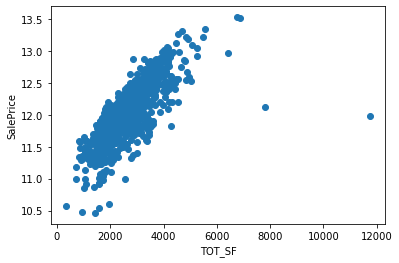

In [23]:
#Plot train ONLY to review SalePrice outliers
print('comb:', comb.shape)
train2=comb.loc[0:1459].copy()
plt.scatter(train2.TOT_SF, train2.SalePrice)
plt.xlabel('TOT_SF')
plt.ylabel('SalePrice')
plt.show()

In [24]:
#drop outliers from comb (not train)
outliers=train2[train2['TOT_SF']>6900].copy()
display(outliers.loc[:,['Id','TOT_SF','SalePrice']])
comb=comb.drop(index=outliers.index,errors='ignore')
print('comb:', comb.shape)

,Id,TOT_SF,SalePrice
523,524,7814.0,12.126764
1298,1299,11752.0,11.982935


comb: (2917, 78)


In [25]:
#Engineer MoSold
MS_dict={'MoSold': {12: 'Winter',
                  1: 'Winter',
                  2: 'Winter',
                  3: 'Spring',
                  4: 'Spring',
                  5: 'Spring',
                  6: 'Summer',
                  7: 'Summer',
                  8: 'Summer',
                  9: 'Fall',
                  10: 'Fall',
                  11: 'Fall'}}

comb.replace(MS_dict, inplace=True)

In [26]:
#Code ordinal features as numbers.
ord_coding={
        'ExterQual' : {'Ex': 5, 'Gd': 4, 'TA':3, 'Fa':2, 'Po':1, "None": 0},
        'BsmtCond' : {'Ex': 5, 'Gd': 4, 'TA':3, 'Fa':2, 'Po':1, "None": 0},
        'BsmtQual' : {'Ex': 5, 'Gd': 4, 'TA':3, 'Fa':2, 'Po':1, "None": 0},
        'ExterCond' : {'Ex': 5, 'Gd': 4, 'TA':3, 'Fa':2, 'Po':1, "None": 0},
        'HeatingQC' : {'Ex': 5, 'Gd': 4, 'TA':3, 'Fa':2, 'Po':1, "None": 0},
        'KitchenQual' : {'Ex': 5, 'Gd': 4, 'TA':3, 'Fa':2, 'Po':1, "None": 0},
        'GarageQual' : {'Ex': 5, 'Gd': 4, 'TA':3, 'Fa':2, 'Po':1, "None": 0},
        'GarageCond' : {'Ex': 5, 'Gd': 4, 'TA':3, 'Fa':2, 'Po':1, "None": 0},
        'LandContour' : {'Lvl': 1, 'Bnk': 2, 'HLS':3, 'Low': 0},
        'BsmtFinType1' : {'GLQ': 3, 'ALQ': 2, 'BLQ':1, 'Rec':2, 'LwQ':1,"Unf":1, "None": 0},
        'BsmtFinType2' : {'GLQ': 3, 'ALQ': 2, 'BLQ':1, 'Rec':2, 'LwQ':1,"Unf":1, "None": 0},
        'GarageFinish' : {'Fin': 3, 'RFn': 2, 'Unf':1, 'None':2},
        'PavedDrive' : {'Y': 3, 'P': 2, 'N':1},
        'Functional' : {'Typ':7, 'Min2':6, 'Min1':5, 'Mod':4, 'Maj1':3, 'Maj2':2, 'Sev':1, 'Sal':0}
       }

comb.replace(ord_coding, inplace=True)

#Convert categorical features to numbers.
cat_feat_to_num = list(ord_coding.keys())
print(cat_feat_to_num)
for c in cat_feat_to_num:
    comb[c]=comb[c].astype('int64')

['ExterQual', 'BsmtCond', 'BsmtQual', 'ExterCond', 'HeatingQC', 'KitchenQual', 'GarageQual', 'GarageCond', 'LandContour', 'BsmtFinType1', 'BsmtFinType2', 'GarageFinish', 'PavedDrive', 'Functional']


In [27]:
#Engineer features part 3.  Combine collinear features to make better features (higher correlation to target).
#Weights are empirically-derived from train only to avoid train-test contamination.
   
comb['ExterQC'] = 0.93*comb['ExterQual'] + 0.07*comb['ExterCond']
comb['GarageQC'] = 0.7*comb['GarageQual'] + 0.3*comb['GarageCond']
comb.drop(columns=['ExterQual','ExterCond','GarageQual','GarageCond'], axis='columns', inplace=True, errors='ignore')

#GarageArea is collinear and redundant with GarageCars.
comb.drop(columns=['GarageArea'], axis='columns', inplace=True, errors='ignore')

In [28]:
comb.tail()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,PavedDrive,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,SalePrice,TOT_SF,House_Age,Yrs_Since_Remod,Total_Bathrooms,Total_Porch_SF,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace,ExterQC,GarageQC
2914,2915,160,RM,21.0,1936,Pave,None,Reg,1,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,Gable,CompShg,CemntBd,CmentBd,None,0.0,CBlock,3,3,No,1,0.0,1,0.0,546.0,546.0,GasA,4,Y,SBrkr,546,546,0,1092,3,1,3,5,7,0,None,None,2,0.0,3,0,None,None,None,0,Summer,WD,Normal,NaN,1638.0,36,36,1.5,0,0,1,0,1,0,3.0,0.0
2915,2916,160,RM,21.0,1894,Pave,None,Reg,1,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,Gable,CompShg,CemntBd,CmentBd,None,0.0,CBlock,3,3,No,2,252.0,1,0.0,294.0,546.0,GasA,3,Y,SBrkr,546,546,0,1092,3,1,3,6,7,0,None,CarPort,1,1.0,3,0,None,None,None,0,Spring,WD,Abnorml,NaN,1638.0,36,36,1.5,24,0,1,1,1,0,3.0,3.0
2916,2917,20,RL,160.0,20000,Pave,None,Reg,1,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,Gable,CompShg,VinylSd,VinylSd,None,0.0,CBlock,3,3,No,2,1224.0,1,0.0,0.0,1224.0,GasA,5,Y,SBrkr,1224,0,0,1224,4,1,3,7,7,1,TA,Detchd,1,2.0,3,0,None,None,None,0,Fall,WD,Abnorml,NaN,2448.0,46,10,2.0,474,0,0,1,1,1,3.0,3.0
2917,2918,85,RL,62.0,10441,Pave,None,Reg,1,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,Gable,CompShg,HdBoard,Wd Shng,None,0.0,PConc,4,3,Av,3,337.0,1,0.0,575.0,912.0,GasA,3,Y,SBrkr,970,0,0,970,3,1,3,6,7,0,None,None,2,0.0,3,0,None,MnPrv,Shed,700,Summer,WD,Normal,NaN,1882.0,14,14,1.5,112,0,0,0,1,0,3.0,0.0
2918,2919,60,RL,74.0,9627,Pave,None,Reg,1,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,HdBoard,HdBoard,BrkFace,94.0,PConc,4,3,Av,1,758.0,1,0.0,238.0,996.0,GasA,5,Y,SBrkr,996,1004,0,2000,3,1,3,9,7,1,TA,Attchd,3,3.0,3,0,None,None,None,0,Fall,WD,Normal,NaN,2996.0,13,12,2.5,238,0,1,1,1,1,3.0,3.0


In [29]:
#Numeric feature is really a category.  Convert.
true_cat = ['MSSubClass']
for c in true_cat:
    comb[c]=comb[c].astype('object')

#### From comb, restore train/test

In [30]:
#First, set comb 'Id' as dataframe index
comb.set_index('Id', inplace=True)

#Restore train and test from comb
train=comb.loc[0:1460].copy()
test=comb.loc[1461:].copy()
display(train.tail(2)); display(test.head(2));

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,PavedDrive,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,SalePrice,TOT_SF,House_Age,Yrs_Since_Remod,Total_Bathrooms,Total_Porch_SF,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace,ExterQC,GarageQC
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1459,20,RL,68.0,9717,Pave,None,Reg,1,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,Hip,CompShg,MetalSd,MetalSd,None,0.0,CBlock,3,3,Mn,3,49.0,2,1029.0,0.0,1078.0,GasA,4,Y,FuseA,1078,0,0,1078,2,1,4,5,7,0,None,Attchd,1,1.0,3,0,None,None,None,0,Spring,WD,Normal,11.864469,2156.0,60,14,2.0,478,0,0,1,1,0,3.00,3.0
1460,20,RL,75.0,9937,Pave,None,Reg,1,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,6,Gable,CompShg,HdBoard,HdBoard,None,0.0,CBlock,3,3,No,1,830.0,1,290.0,136.0,1256.0,GasA,4,Y,SBrkr,1256,0,0,1256,3,1,3,6,7,0,None,Attchd,3,1.0,3,0,None,None,None,0,Summer,WD,Normal,11.901590,2512.0,43,43,2.5,804,0,0,1,1,0,3.93,3.0


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,PavedDrive,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,SalePrice,TOT_SF,House_Age,Yrs_Since_Remod,Total_Bathrooms,Total_Porch_SF,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace,ExterQC,GarageQC
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,None,Reg,1,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,Gable,CompShg,VinylSd,VinylSd,None,0.0,CBlock,3,3,No,2,468.0,1,144.0,270.0,882.0,GasA,3,Y,SBrkr,896,0,0,896,2,1,3,5,7,0,None,Attchd,1,1.0,3,0,None,MnPrv,None,0,Summer,WD,Normal,NaN,1778.0,49,49,1.0,260,0,0,1,1,0,3.0,3.0
1462,20,RL,81.0,14267,Pave,None,IR1,1,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,CBlock,3,3,No,2,923.0,1,0.0,406.0,1329.0,GasA,3,Y,SBrkr,1329,0,0,1329,3,1,4,6,7,0,None,Attchd,1,1.0,3,0,None,None,Gar2,12500,Summer,WD,Normal,NaN,2658.0,52,52,1.5,429,0,0,1,1,0,3.0,3.0


In [31]:
print('Train feature correlations to SalePrice:\n')
train.corr()['SalePrice'].sort_values(ascending=False).round(4)

Train feature correlations to SalePrice:



SalePrice          1.0000
TOT_SF             0.8253
OverallQual        0.8214
GrLivArea          0.7252
ExterQC            0.6835
GarageCars         0.6810
Total_Bathrooms    0.6767
KitchenQual        0.6700
TotalBsmtSF        0.6476
1stFlrSF           0.6205
BsmtQual           0.6169
TotRmsAbvGrd       0.5377
hasfireplace       0.5103
GarageFinish       0.4963
Fireplaces         0.4920
HeatingQC          0.4739
MasVnrArea         0.4306
BsmtFinType1       0.4101
Total_Porch_SF     0.3997
BsmtFinSF1         0.3923
LotFrontage        0.3697
GarageQC           0.3644
hasgarage          0.3230
2ndFlrSF           0.3200
PavedDrive         0.3047
BsmtCond           0.2745
LotArea            0.2605
BsmtUnfSF          0.2219
BedroomAbvGr       0.2090
hasbsmt            0.1996
has2ndfloor        0.1506
Functional         0.1344
BsmtFinType2       0.0897
haspool            0.0765
PoolArea           0.0743
LandContour        0.0254
BsmtFinSF2         0.0049
MiscVal           -0.0200
OverallCond 

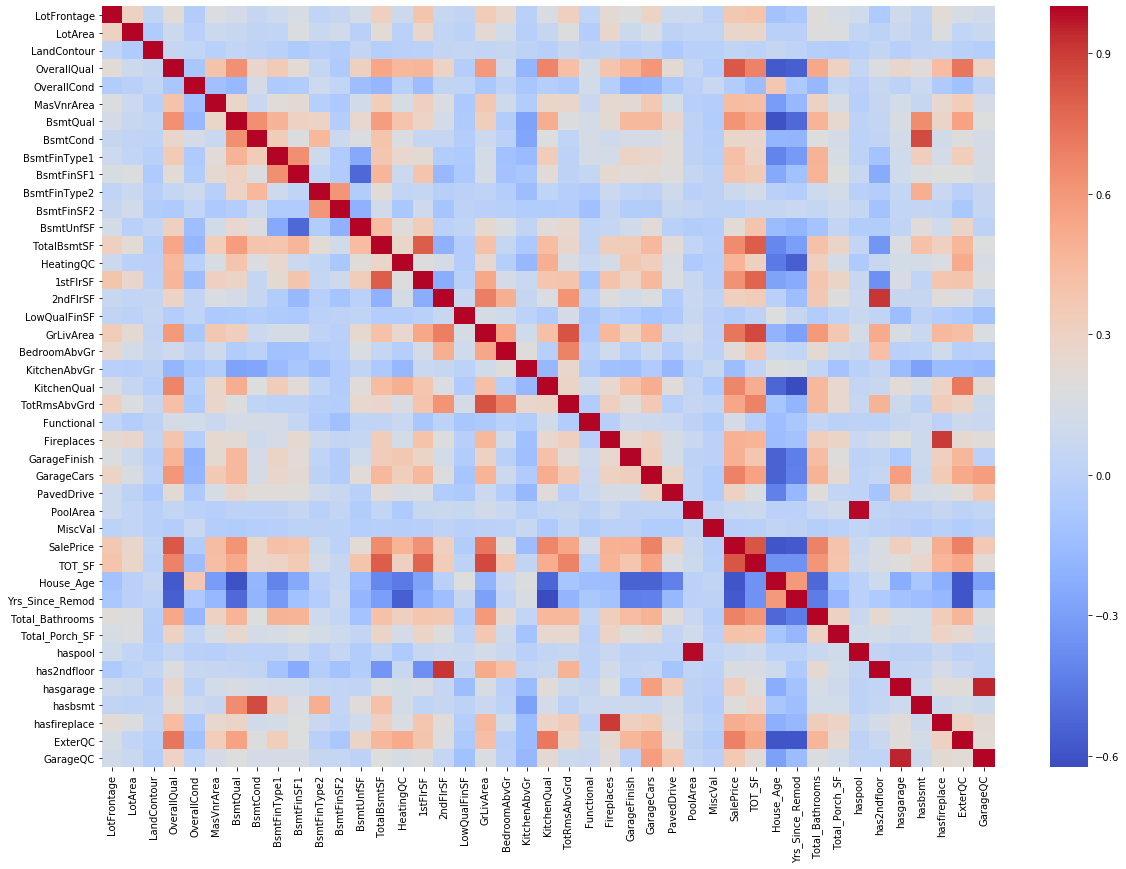

In [32]:
#View collinear features.  Revert matplotlib from 3.1.1 to 3.1.0 if squares are truncated (matplotlib bug).
fig, ax = plt.subplots(figsize=(20, 14))
sns.heatmap(train.corr(), cmap='coolwarm')
plt.show()

### `Skew Reduction Toolkit`

In [33]:
def get_left_skew_power(df, feature, target):
    '''
    Find feature power transform with the highest correlation to target.
    The correlation is the absolute correlation between transformed 
    feature and target.
    '''
    from scipy.stats import skew

    #initialize benchmarks and results list
    targetArr = df[target].values
    origCorr = abs(np.corrcoef(df[feature].values, targetArr)[1,0])  #get absolute correlation coeff for two-set case.
    origSkew = skew(df[feature].values)
    results=[]

    #Try different powers on feature.  Record results for correlation and skew by power
    for pwr in np.arange(0.1, 10.1, 0.1):
        featArr=df[feature].values  #restore feature for next trial
        featArr = featArr**pwr
        newCorr=abs(np.corrcoef(featArr, targetArr)[0,1])  #absolute value of feature-target correlation
        newSkew = skew(featArr)     
        results.append([round(pwr,1), round(newSkew,4), round(newCorr,4)])
    results.append([1, round(origSkew,4), round(origCorr,4)])

    #Convert list to np.array.  Get the power for the highest correlation.
    resultArr=np.array(results)
    idx = np.argmax(resultArr[:,2], axis=0)   # get index of highest correlation in column 2
    #define best variables as those tied to the highest abs correlation
    bestPwr, bestSkew, bestCorr = resultArr[idx,0], resultArr[idx,1], resultArr[idx,2]
    origPwr, origSkew, origCorr = resultArr[-1,0], resultArr[-1,1], resultArr[-1,2]
    print(f'#{feature}:', 'OrigPwr, bestPwr:', origPwr, ',', bestPwr, '|', 'origSkew, bestSkew:', origSkew, ',', bestSkew, '|', 'origCorr, bestCorr:', origCorr, ',', bestCorr,'\n')
    
    if (abs(origSkew) > abs(bestSkew)) and (bestCorr > origCorr):
        return bestPwr #return best power if skew and correlation both improve
    else:
        return 1       #do nothing to feature - raise feature to 1st power

In [34]:
def lower_skew(train, test, skewness_thresh, rightFixOn=True, leftFixOn=True):
    '''
    Lower skew of numeric features.  Takes df inputs and transforms feature, lowering skew.
    Returns transformed features df and dictionary of before & after skew.  For left
    skewnes, power 2 is the default.  Higher powers may overcorrect certain features.
    '''
    from scipy.stats import skew
    from scipy.stats import boxcox
    trn=train.copy(); tst=test.copy();
    before_after={}; before_after['train']={}; before_after['test']={};        
    numeric_cols = list(trn.select_dtypes(exclude='object').columns)    
    
    for c in numeric_cols:
        skewTrnOrig = skew(trn[c])
        skewTstOrig = skew(tst[c])
        if (skewTrnOrig > skewness_thresh and rightFixOn):      #Right skew scenario.  Work with temporary series.  
            trn[c], lam = boxcox(trn[c] + 1)  #Compress right tail with boxcox log-like trransform     
            tst[c] = boxcox(tst[c] + 1, lam)
            
            if (abs(skew(trn[c])) < abs(skewTrnOrig)) and (abs(skew(tst[c])) < abs(skewTstOrig)):  #if skew improves
                train[c], lam = boxcox(train[c] + 1)
                test[c] = boxcox(test[c] + 1, lam)  #apply train feature lambda to test feature to avoid leakage
                before_after['train'][c] = [round(skewTrnOrig,2), round(skew(trn[c]),2)]
                before_after['test'][c] = [round(skewTstOrig,2), round(skew(tst[c]),2)] 
            
            else:
                print(f'{c} worse in trn or tst -- no transform applied.')
                print(f'trn orig: {round(skewTrnOrig,2)} | trn new: {round(skew(trn[c]),2)}    tst orig: {round(skewTstOrig,2)} | tst new: {round(skew(tst[c]),2)}\n')
                
        elif (skewTrnOrig < -skewness_thresh and leftFixOn):     #Left skew scenario.
            leftSkew_exp = get_left_skew_power(df=train, feature=c, target='SalePrice')
            trn[c] = (trn[c])**leftSkew_exp   #Expand right tail with squaring-like transform
            tst[c] = (tst[c])**leftSkew_exp
                
            if (abs(skew(trn[c])) < abs(skewTrnOrig)) and (abs(skew(tst[c])) < abs(skewTstOrig)):  #if skew improves
                train[c] = (train[c])**leftSkew_exp           
                test[c] = (test[c])**leftSkew_exp
                before_after['train'][c] = [round(skewTrnOrig,2), round(skew(trn[c]),2)]
                before_after['test'][c] = [round(skewTstOrig,2), round(skew(tst[c]),2)]
                                    
            else:
                print(f'{c} worse in trn or tst -- no transform applied.')
                print(f'trn orig: {round(skewTrnOrig,2)} | trn new: {round(skew(trn[c]),2)}    tst orig: {round(skewTstOrig,2)} | tst new: {round(skew(tst[c]),2)}\n')
                          
        else:   #Skew is below skewness_thresh
            continue
       
    return train, test, before_after

In [35]:
#Lower skew
train, test, before_after = lower_skew(train=train, test=test, skewness_thresh=0.5)

OverallCond worse in trn or tst -- no transform applied.
trn orig: 0.69 | trn new: 0.03    tst orig: 0.45 | tst new: -0.64

#BsmtQual: OrigPwr, bestPwr: 1.0 , 2.5 | origSkew, bestSkew: -1.2932 , 0.728 | origCorr, bestCorr: 0.6169 , 0.6739 

#BsmtCond: OrigPwr, bestPwr: 1.0 , 1.3 | origSkew, bestSkew: -3.6943 , -2.6916 | origCorr, bestCorr: 0.2745 , 0.2779 

#HeatingQC: OrigPwr, bestPwr: 1.0 , 3.1 | origSkew, bestSkew: -0.5377 , -0.2503 | origCorr, bestCorr: 0.4739 , 0.4792 

KitchenAbvGr worse in trn or tst -- no transform applied.
trn orig: 4.48 | trn new: -2.8    tst orig: 4.07 | tst new: -6.24

#Functional: OrigPwr, bestPwr: 1.0 , 1.4 | origSkew, bestSkew: -4.9655 , -4.6682 | origCorr, bestCorr: 0.1344 , 0.1346 

#PavedDrive: OrigPwr, bestPwr: 1.0 , 1.7 | origSkew, bestSkew: -3.3027 , -3.2238 | origCorr, bestCorr: 0.3047 , 0.3053 

haspool worse in trn or tst -- no transform applied.
trn orig: 15.49 | trn new: 15.49    tst orig: 15.5 | tst new: 15.5

#hasgarage: OrigPwr, bestPwr: 1.

In [36]:
before_after

{'train': {'LotFrontage': [1.55, 0.17],
  'LotArea': [12.56, 0.04],
  'LandContour': [2.76, -0.13],
  'MasVnrArea': [2.69, 0.43],
  'BsmtQual': [-1.29, 0.73],
  'BsmtCond': [-3.69, -2.69],
  'BsmtFinSF1': [0.76, -0.42],
  'BsmtFinType2': [2.28, 0.16],
  'BsmtFinSF2': [4.25, 2.42],
  'BsmtUnfSF': [0.92, -0.27],
  'TotalBsmtSF': [0.51, -0.03],
  'HeatingQC': [-0.54, -0.25],
  '1stFlrSF': [0.89, 0.0],
  '2ndFlrSF': [0.81, 0.28],
  'LowQualFinSF': [9.0, 7.29],
  'GrLivArea': [1.01, 0.0],
  'TotRmsAbvGrd': [0.66, 0.0],
  'Functional': [-4.97, -4.67],
  'Fireplaces': [0.63, 0.08],
  'PavedDrive': [-3.3, -3.22],
  'PoolArea': [15.93, 15.49],
  'MiscVal': [24.43, 5.01],
  'TOT_SF': [0.8, 0.03],
  'House_Age': [0.61, -0.23],
  'Yrs_Since_Remod': [0.5, -0.16],
  'Total_Porch_SF': [1.1, -0.38],
  'ExterQC': [0.8, -0.03],
  'GarageQC': [-3.34, -2.91]},
 'test': {'LotFrontage': [0.62, -0.2],
  'LotArea': [3.11, -0.8],
  'LandContour': [2.88, 0.76],
  'MasVnrArea': [2.55, 0.49],
  'BsmtQual': [-1.25

### Full X and y train data

In [37]:
#Get full X and y from train.  
train_y_full=train['SalePrice'].copy()
train_X_full=train.drop(['SalePrice'], axis='columns').copy()

#Get full X from test.
test_X_full=test.drop(['SalePrice'], axis='columns').copy()
print('train_X_full shape:',train_X_full.shape)
print('test_X_full shape:',test_X_full.shape)

train_X_full shape: (1458, 73)
test_X_full shape: (1459, 73)


[['Utilities', 0.99931, dtype('O')],
 ['Street', 0.99588, dtype('O')],
 ['PoolArea', 0.99588, dtype('float64')],
 ['PoolQC', 0.99588, dtype('O')],
 ['haspool', 0.99588, dtype('int64')],
 ['Condition2', 0.9904, dtype('O')],
 ['RoofMatl', 0.98285, dtype('O')],
 ['LowQualFinSF', 0.98217, dtype('float64')],
 ['Heating', 0.97805, dtype('O')],
 ['hasbsmt', 0.97462, dtype('int64')]]

Features where top value is big percentage of train_X_full:


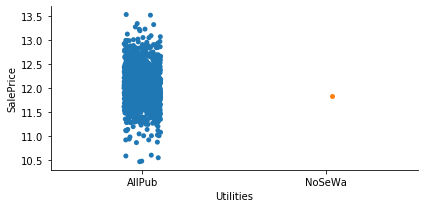

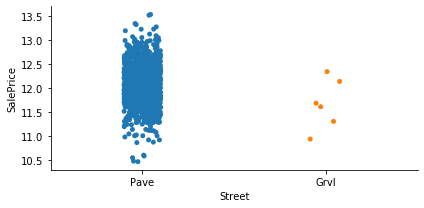

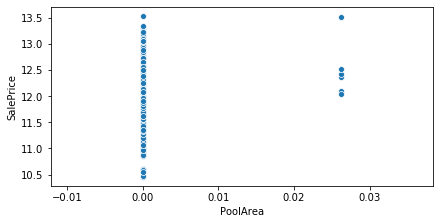

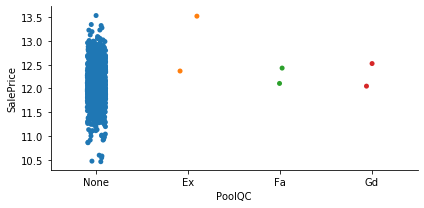

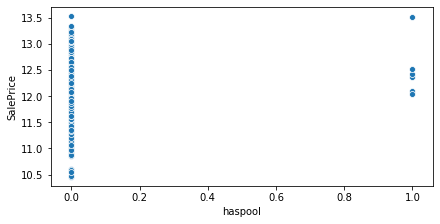

In [38]:
#Invariant features.  Explore features where most common value is most of the total.
top_val_pct=[]
for c in train_X_full.columns:
    top_val_pct.append([c, round(train_X_full[c].value_counts().values[0] / len(train_X_full),5), train_X_full[c].dtype])
display(sorted(top_val_pct, key=lambda idx: idx[1], reverse=True)[0:10])

print('Features where top value is big percentage of train_X_full:')
sns.catplot(x='Utilities',y='SalePrice', data=train, height=3, aspect=2)
sns.catplot(x='Street',y='SalePrice', data=train, height=3, aspect=2)
fig, ax1 = plt.subplots(figsize=(6,3),constrained_layout=True)
sns.scatterplot(x='PoolArea',y='SalePrice', data=train, ax=ax1)
sns.catplot(x='PoolQC',y='SalePrice', data=train, height=3, aspect=2)
fig, ax2 = plt.subplots(figsize=(6,3),constrained_layout=True)
sns.scatterplot(x='haspool',y='SalePrice', data=train, ax=ax2)
plt.show()

#Per the charts below, drop the low information category features.  Keep the numerics which have 0.07 correl.
#PoolQC would add four dimensions with little useful data. Also, drop MiscVal due to Scaler issue and low corr.
train_X_full.drop(['Utilities','PoolQC','Street','MiscVal'], axis=1, inplace=True, errors='ignore')
test_X_full.drop(['Utilities','PoolQC','Street','MiscVal'], axis=1, inplace=True, errors='ignore')

### Scale Numeric Features

In [39]:
def scale_num_df(train_df, test_df, numer_cols, scaler):
    #fit_transform train
    scaled_trn_num_df = pd.DataFrame(scaler.fit_transform(train_df[numer_cols]))
    scaled_trn_num_df.index=train_df.index
    scaled_trn_num_df.columns=train_df[numer_cols].columns
    display(scaled_trn_num_df.tail(2))

    #transform test
    scaled_tst_num_df = pd.DataFrame(scaler.transform(test_df[numer_cols]))
    scaled_tst_num_df.index=test_df.index
    scaled_tst_num_df.columns=test_df[numer_cols].columns
    display(scaled_tst_num_df.head(2))
    return scaled_trn_num_df, scaled_tst_num_df

In [40]:
# #Get numeric scalable features - those not skew-transformed or binary.
# all_num_cols = set(train_X_full.select_dtypes(exclude='object').columns)

# skewed = set(before_after['train'].keys())
# bin_feat=set(['haspool','has2ndfloor','hasgarage','hasbsmt','hasfireplace'])
# num_scalable = all_num_cols - skewed - bin_feat
# print('Numeric Scalable features:', num_scalable)

# #Review train scalable columns. 

# lower_mag_cols=['LotFrontage','LotArea','BsmtQual','BsmtCond','BsmtFinSF1','BsmtUnfSF', 'TotalBsmtSF',
#                 'HeatingQC','GrLivArea','Functional', 'GarageArea','GarageQual','GarageCond','TOT_SF',
#                 'House_Age','Total_Porch_SF']

# for c in lower_mag_cols:
#     fig, (ax1, ax2) = plt.subplots(1,2,figsize=[8,3], constrained_layout=True)    
#     ax1.scatter(train[c], train['SalePrice'])
#     ax1.set_title(f'{c} vs SalePrice', size=12); ax1.set_xlabel(f'{c}'); ax1.set_ylabel('SalePrice');    
#     ax2.hist(train[c])
#     ax2.set_title(f'{c} Histogram', size=12); ax2.set_xlabel(f'{c}'); ax2.set_ylabel('Count'); 

### `Robust and Uniform Scalers`

In [41]:
#Experiment with scaling feature by factor of 10.
def uniform_scaler(train, test, num_cols):
    before_after2={}
    for cnt, c in enumerate(num_cols):
        abs_max=round(abs(train[c].max()),2)
        if 10 < abs_max <= 100:
            train[c]=train[c]/10
            test[c]=test[c]/10     
            
            before_after2[c] = [abs_max, round(abs(train[c].max()),2)]
            print(f'{cnt} {c} abs max after scaling:', round(abs(train[c].max()),2))
        elif 100 < abs_max <= 1000:
            train[c]=train[c]/100
            test[c]=test[c]/100
            before_after2[c] = [abs_max, round(abs(train[c].max()),2)]
            print(f'{cnt} {c} abs max after scaling:', round(abs(train[c].max()),2))
        elif 1000 < abs_max <= 10_000:
            train[c]=train[c]/1000
            test[c]=test[c]/1000
            before_after2[c] = [abs_max, round(abs(train[c].max()),2)]
            print(f'{cnt} {c} abs max after scaling:', round(abs(train[c].max()),2))        
        elif 10_000 < abs_max <= 100_000:
            train[c]=train[c]/10_000
            test[c]=test[c]/10_1000
            before_after2[c] = [abs_max, round(abs(train[c].max()),2)]
            print(f'{cnt} {c} abs max after scaling:', round(abs(train[c].max()),2))
        elif abs_max > 100_000:
            print('ERROR: feature max value outside scaler range')
        else:
            pass
    return train, test, before_after2

In [42]:
#Scale. Use "num_scalable" with Scaler.  Use "all_num_cols" with row-based Normalizer. 
# num_scalable=list(num_scalable)
#num_scalable.remove('SalePrice')
# all_num_cols=list(all_num_cols)

# # Sklearn scaler
# train_X_full[num_scalable], test_X_full[num_scalable]=scale_num_df(train_df=train_X_full, test_df=test_X_full,
#                                                                numer_cols=num_scalable, scaler=RobustScaler())


# #Uniform scale features with abs maxes > 10.
# lower_mag_cols=['LotFrontage','LotArea','BsmtQual','BsmtCond','BsmtFinSF1','BsmtUnfSF', 'TotalBsmtSF',
#                 'HeatingQC','GrLivArea','Functional', 'GarageArea','GarageQual','GarageCond','TOT_SF',
#                 'House_Age','Total_Porch_SF']
# train_X_full, test_X_full, before_after2 = uniform_scaler(train=train_X_full, test=test_X_full, num_cols=lower_mag_cols)

In [43]:
# #Review scalable columns after Scaler
# for c in lower_mag_cols:
#     fig, (ax1, ax2) = plt.subplots(1,2,figsize=[8,3], constrained_layout=True)    
#     ax1.scatter(train_X_full[c], train_y_full)
#     ax1.set_title(f'{c} vs SalePrice', size=12); ax1.set_xlabel(f'{c}'); ax1.set_ylabel('SalePrice');    
#     ax2.hist(train_X_full[c])
#     ax2.set_title(f'{c} Histogram', size=12); ax2.set_xlabel(f'{c}'); ax2.set_ylabel('Count'); 

### One-Hot Encoding Categorical Features

###### `One-Hot Categorical Features function`

In [44]:
categ_cols=list(train_X_full.select_dtypes(include='object').columns)
print(categ_cols)

['MSSubClass', 'MSZoning', 'Alley', 'LotShape', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtExposure', 'Heating', 'CentralAir', 'Electrical', 'FireplaceQu', 'GarageType', 'Fence', 'MiscFeature', 'MoSold', 'SaleType', 'SaleCondition']


In [45]:
def one_hot_encode(train_df, test_df, cat_cols):
    '''
    One-Hot Encode train category columns.  Apply identical encoding to test.
    Unknown category in test handled by returning all zeroes column.  Function
    keeps original dataframe indices intact.
    '''
    ohe = OneHotEncoder(sparse=False, drop=None, handle_unknown='ignore')  #drop None or 'first'
    #fit_transform train cat_cols.
    ohe_train_df=pd.DataFrame(ohe.fit_transform(train_df[cat_cols]))
    ohe_train_df.index=train_df.index
    ohe_train_df.columns=ohe.get_feature_names(cat_cols)
    #Based on train cat_cols, transform test.  Unknown test category gets zeros per 'ignore' above.
    ohe_test_df=pd.DataFrame(ohe.transform(test_df[cat_cols]))
    ohe_test_df.index=test_df.index
    ohe_test_df.columns=ohe.get_feature_names(cat_cols)
    return ohe_train_df, ohe_test_df

#One-Hot Encode full train and test.
ohe_train_df, ohe_test_df = one_hot_encode(train_df=train_X_full, test_df=test_X_full, cat_cols=categ_cols)

In [46]:
#Drop original category columns.  Add OHE category columns.
train_X_full = train_X_full.drop(columns=categ_cols, axis='columns', errors='ignore')
test_X_full = test_X_full.drop(columns=categ_cols, axis='columns', errors='ignore')

train_X_full = pd.concat([train_X_full, ohe_train_df], axis='columns')
test_X_full = pd.concat([test_X_full, ohe_test_df], axis='columns')

In [47]:
#Check train and test columns mismatch
train_X_full_col = set(list(train_X_full.columns))
test_X_full_col = set(list(test_X_full.columns))

test_X_full_col-train_X_full_col

set()

### 49 Noise Features at 0.995 pct zeros cutoff:  ###

Count nonzero - 6 :


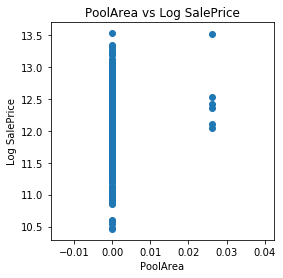

Count nonzero - 6 :


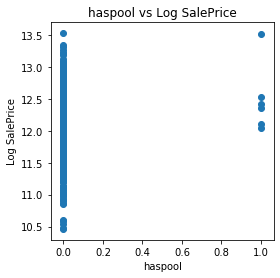

Count nonzero - 4 :


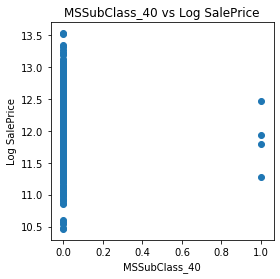

Count nonzero - 4 :


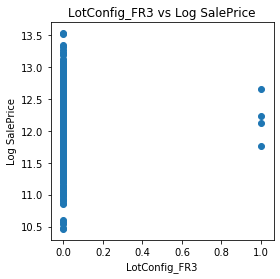

Count nonzero - 2 :


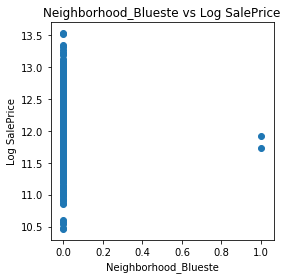

Count nonzero - 2 :


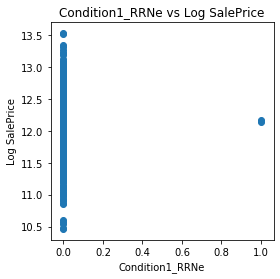

Count nonzero - 5 :


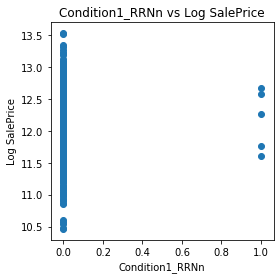

Count nonzero - 2 :


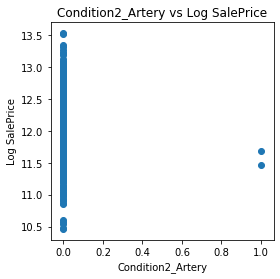

Count nonzero - 6 :


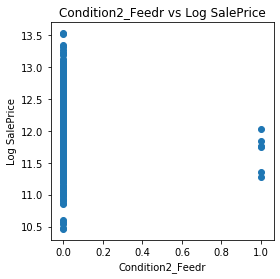

Count nonzero - 1 :


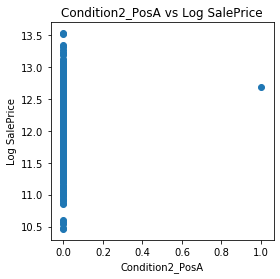

Count nonzero - 1 :


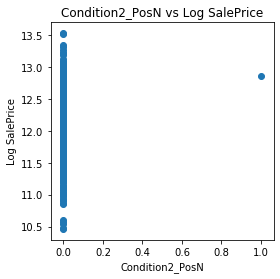

Count nonzero - 1 :


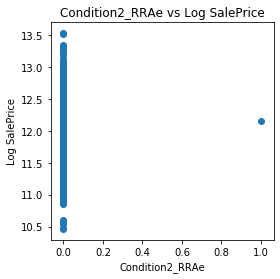

Count nonzero - 1 :


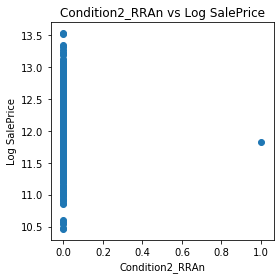

Count nonzero - 2 :


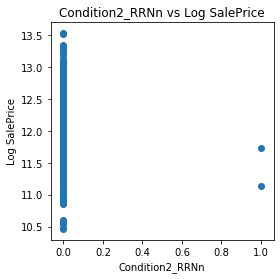

Count nonzero - 7 :


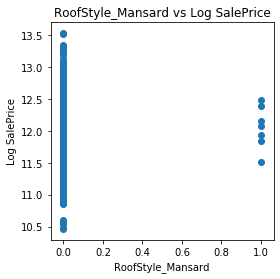

Count nonzero - 2 :


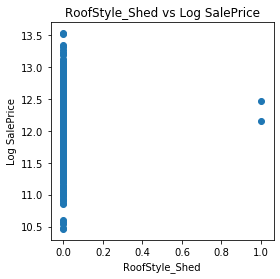

Count nonzero - 1 :


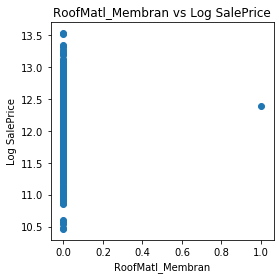

Count nonzero - 1 :


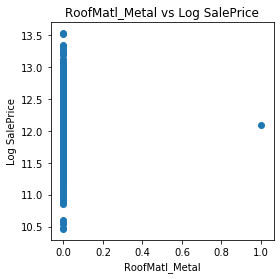

Count nonzero - 1 :


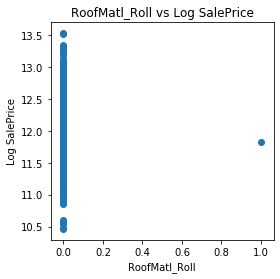

Count nonzero - 5 :


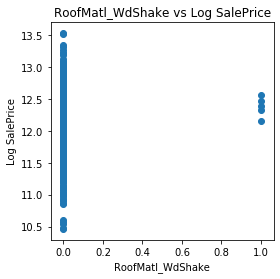

Count nonzero - 6 :


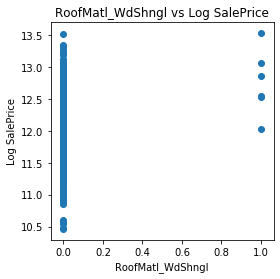

Count nonzero - 1 :


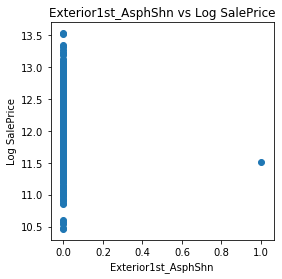

Count nonzero - 2 :


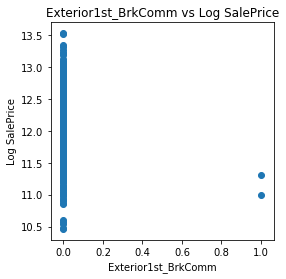

Count nonzero - 1 :


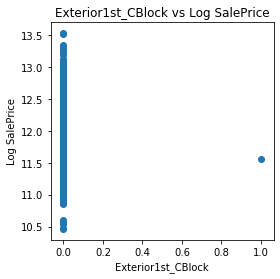

Count nonzero - 1 :


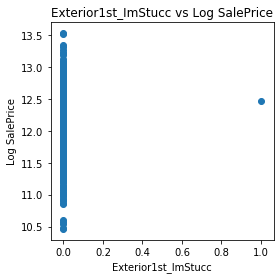

Count nonzero - 2 :


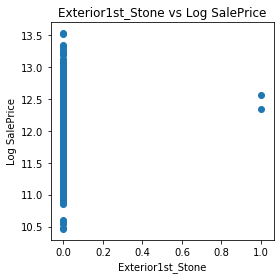

Count nonzero - 3 :


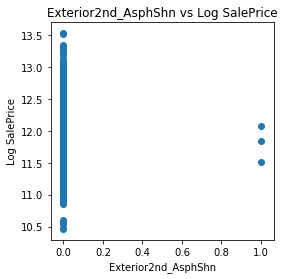

Count nonzero - 7 :


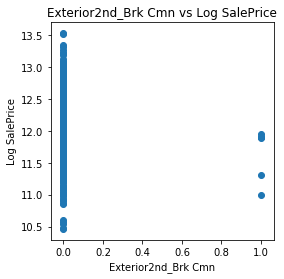

Count nonzero - 1 :


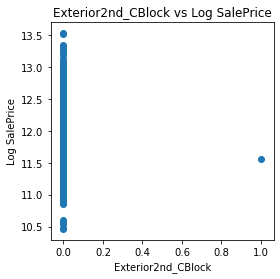

Count nonzero - 1 :


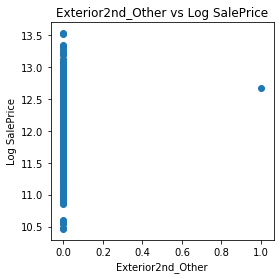

Count nonzero - 5 :


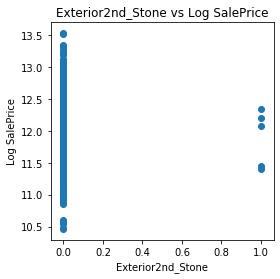

Count nonzero - 6 :


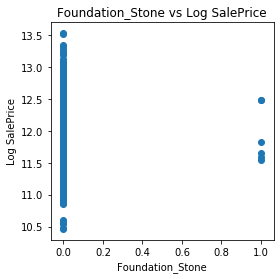

Count nonzero - 3 :


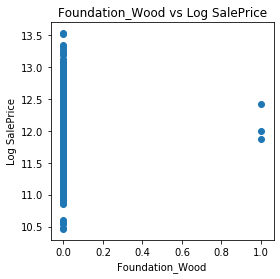

Count nonzero - 1 :


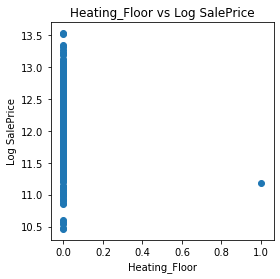

Count nonzero - 7 :


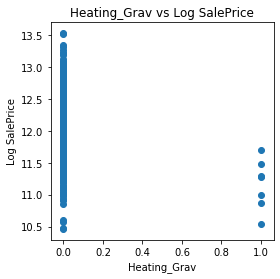

Count nonzero - 2 :


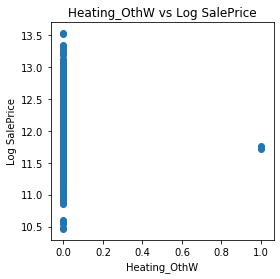

Count nonzero - 4 :


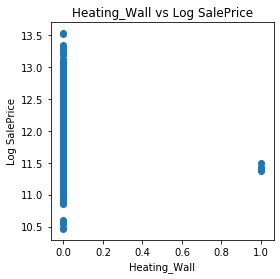

Count nonzero - 3 :


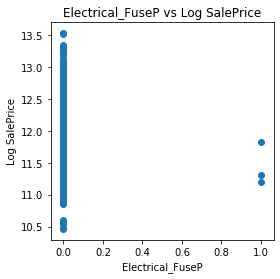

Count nonzero - 1 :


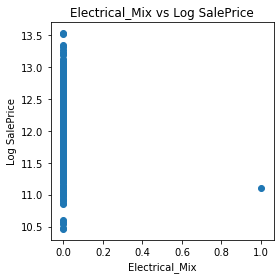

Count nonzero - 6 :


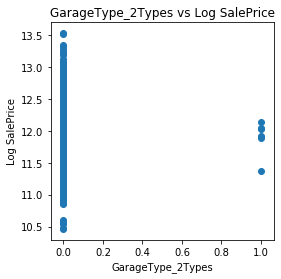

Count nonzero - 2 :


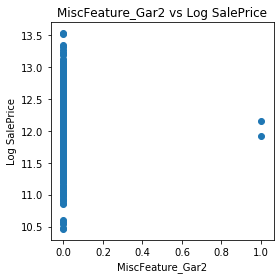

Count nonzero - 2 :


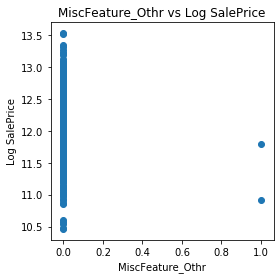

Count nonzero - 1 :


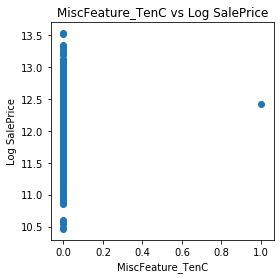

Count nonzero - 4 :


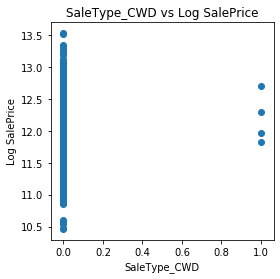

Count nonzero - 2 :


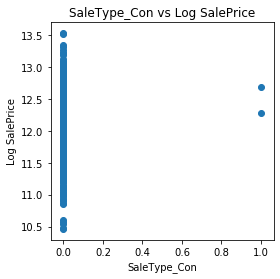

Count nonzero - 5 :


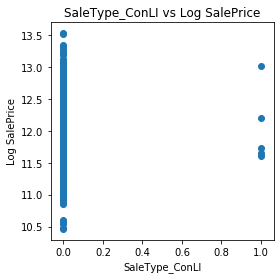

Count nonzero - 5 :


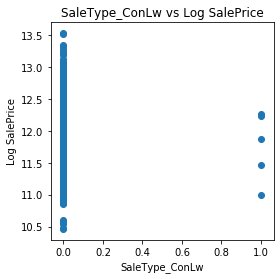

Count nonzero - 3 :


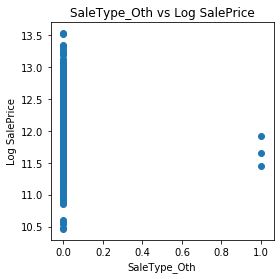

Count nonzero - 4 :


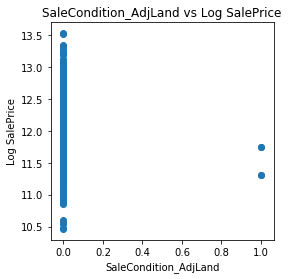

In [48]:
#Review noise features - where one category is nearly all observations.
noise_feat = []
pct_zeros = .995
for i in train_X_full.columns:
    counts = train_X_full[i].value_counts()
    zeros = counts.iloc[0]  #top frequency category    
    if zeros / len(train_X_full) > pct_zeros:
        noise_feat.append(i)

print(f'### {len(noise_feat)} Noise Features at {pct_zeros} pct zeros cutoff:  ###\n')

for c in noise_feat:
    counts = train_X_full[c].value_counts()
    zeros = counts.iloc[0]  #top frequency category
    print('Count nonzero -', (len(train_X_full[c]) - zeros),':')
    plt.figure(figsize=[4,4])
    plt.scatter(train_X_full[c], train_y_full)
    plt.title(f'{c} vs Log SalePrice'); plt.xlabel(f'{c}'); plt.ylabel('Log SalePrice');
    plt.show()   

In [49]:
# #Drop noise features.  Will help non-regularized models by reducing dimensionality.
train_X_full = train_X_full.drop(columns=noise_feat, axis='columns', errors='ignore')
test_X_full = test_X_full.drop(columns=noise_feat, axis='columns', errors='ignore')

In [50]:
# #Drop multicollinear features.
# train_X_full = train_X_full.drop(columns=multico_cols, axis='columns', errors='ignore')
# test_X_full = test_X_full.drop(columns=multico_cols, axis='columns', errors='ignore')

In [51]:
def get_PCA(train, test):
    '''
    Takes numeric dataframe and returns principal components dataframes with the
    same shape, indices, and numbered column names.
    '''
    pca = PCA(n_components=None)
    trainPC = pca.fit_transform(train)  #get train PC
    trainPC = pd.DataFrame(trainPC, index=train.index).add_prefix('PC')
    trnCumSum=np.cumsum(pca.explained_variance_ratio_)
    testPC = pca.transform(test)        #test is projected on the PCs previously extracted from train
    testPC = pd.DataFrame(testPC, index=test.index).add_prefix('PC')
    return trainPC, testPC, trnCumSum

In [52]:
# # ****PCA Transform the data****

# #Get all principal components of train and apply same transformation to test.
# train_X_full, test_X_full, trnCumSum = get_PCA(train_X_full, test_X_full)

# #keep 101 principal components
# train_X_full.drop(train_X_full.iloc[0,101:].index, axis='columns', inplace=True, errors='ignore')
# test_X_full.drop(test_X_full.iloc[0,101:].index, axis='columns', inplace=True, errors='ignore')

# #print reduced dimensions
# print('train_X_full:', train_X_full.shape)
# print('test_X_full:', test_X_full.shape)
# display(train_X_full.head(2))
# display(test_X_full.head(2))

## Cross-Validation

### `Set aside holdout data from train`

In [53]:
#Set aside holdout data from train
from sklearn.model_selection import train_test_split
train_X, holdout_X, train_y, holdout_y = train_test_split(train_X_full, train_y_full, test_size=0.20,random_state=11, shuffle=True)

In [54]:
from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error

def train_and_valid(what_model, num_folds, X, y):
    fold_rsme=[]
    kf=KFold(n_splits=num_folds, shuffle=True, random_state=30)    
        
    for train_index, valid_index in kf.split(X):                         #split train data excluding holdout
        #Clone is copy of model not yet fit on any data.  Initial conditions impact certain model results, like SGD.
        clone_model = clone(what_model)                                  
        trn_X, valid_X = X.iloc[train_index, :], X.iloc[valid_index, :]  #df has columns
        trn_y, valid_y = y.iloc[train_index], y.iloc[valid_index]        #series no columns

        clone_model.fit(trn_X, trn_y)
        valid_pred=clone_model.predict(valid_X)
        rmse=round(np.sqrt(mean_squared_error(valid_y, valid_pred)), 6)
        fold_rsme.append(rmse)
    return fold_rsme, clone_model

In [55]:
#Train and Score LR CV
lr=LinearRegression(fit_intercept=True)
fold_rsme, linMod = train_and_valid(what_model=lr, num_folds=10, X=train_X, y=train_y)
print('Fold RSME:', fold_rsme)
print('## Avg RMSE:', round(np.mean(fold_rsme),4),'+-', round(np.std(fold_rsme),4))
print('## LR R^2:', round(linMod.score(train_X, train_y),3))

#Score holdout
holdout_pred = linMod.predict(holdout_X)
print('\n## holdout RMSE:', round(np.sqrt(mean_squared_error(holdout_y, holdout_pred)), 4))
print('## holdout LR R^2:', round(linMod.score(holdout_X, holdout_y),4))

Fold RSME: [0.132552, 0.104123, 0.099653, 0.099584, 0.107409, 0.107024, 0.127187, 0.092271, 0.106643, 0.125007]
## Avg RMSE: 0.1101 +- 0.0127
## LR R^2: 0.951

## holdout RMSE: 0.1386
## holdout LR R^2: 0.8724


In [56]:
#Train and Score las CV
las=Lasso(alpha=.001)
fold_rsme, lasMod = train_and_valid(what_model=las, num_folds=10, X=train_X, y=train_y)
print('Fold RSME:', fold_rsme)
print('## Avg RMSE:', round(np.mean(fold_rsme),4),'+-', round(np.std(fold_rsme),4))
print('## las R^2:', round(lasMod.score(train_X, train_y),3))

#Score holdout
holdout_pred = lasMod.predict(holdout_X)
print('\n## holdout RMSE:', round(np.sqrt(mean_squared_error(holdout_y, holdout_pred)), 4))
print('## holdout las R^2:', round(lasMod.score(holdout_X, holdout_y),4))

Fold RSME: [0.162128, 0.092563, 0.098753, 0.10595, 0.107613, 0.092459, 0.118002, 0.092863, 0.092421, 0.119472]
## Avg RMSE: 0.1082 +- 0.0205
## las R^2: 0.938

## holdout RMSE: 0.1242
## holdout las R^2: 0.8975


In [57]:
#Train and Score Ridge CV
ridge=Ridge(alpha=15)
fold_rsme, ridgeMod = train_and_valid(what_model=ridge, num_folds=10, X=train_X, y=train_y)
print('Fold RSME:', fold_rsme)
print('## Avg RMSE:', round(np.mean(fold_rsme),4),'+-', round(np.std(fold_rsme),4))
print('## ridge R^2:', round(ridgeMod.score(train_X, train_y),3))

#Score holdout
holdout_pred = ridgeMod.predict(holdout_X)
print('\n## holdout RMSE:', round(np.sqrt(mean_squared_error(holdout_y, holdout_pred)), 4))
print('## holdout R^2:', round(ridgeMod.score(holdout_X, holdout_y),4))

Fold RSME: [0.155968, 0.09029, 0.098202, 0.10716, 0.10821, 0.094398, 0.115805, 0.091149, 0.091882, 0.120726]
## Avg RMSE: 0.1074 +- 0.0191
## ridge R^2: 0.943

## holdout RMSE: 0.1213
## holdout R^2: 0.9023


### `Train Final Model on Full Data and Do Predictions`

In [58]:
train_X_full.shape

(1458, 196)

#### Full Data CV metrics - worse avg error across 25% more samples, better error stability; better R^2

In [59]:
#Train and Score Final Model on FULL data
ridge_cv=Ridge(alpha=15)

fold_rsme, ridge_cvMod = train_and_valid(what_model=ridge_cv, num_folds=10, X=train_X_full, y=train_y_full)
print('Fold RSME:', fold_rsme)
print('## Avg RMSE:', round(np.mean(fold_rsme),4),'+-', round(np.std(fold_rsme),4))
print('## ridge_cv R^2:', round(ridge_cvMod.score(train_X_full, train_y_full),4))

Fold RSME: [0.098202, 0.126168, 0.100152, 0.109617, 0.101499, 0.092705, 0.125766, 0.102563, 0.113872, 0.11759]
## Avg RMSE: 0.1088 +- 0.0111
## ridge_cv R^2: 0.9376


#### FINAL - Best Model (no CV) for Kaggle Predictions

In [60]:
from sklearn.metrics import mean_squared_error
rr=Ridge(alpha=15)
rr.fit(train_X_full, train_y_full)
y_pred_rr=rr.predict(train_X_full)
RMSE = rmse=round(np.sqrt(mean_squared_error(train_y_full, y_pred_rr)), 4)
print('RMSE:', RMSE)
print('R^2:', round(rr.score(train_X_full, train_y_full),4))

RMSE: 0.0987
R^2: 0.939


#### Do Kaggle Predictions

In [61]:
#Predict test and inverse normalize prediction.  Johnson normalization would need inversion.
test_pred=rr.predict(test_X_full)
test_pred=np.exp(test_pred)-1
test_pred[0:5]

array([113371.79600699, 164529.67606946, 182450.76112001, 195156.87762842,
       188412.84813236])

In [62]:
#Kaggle Submission - Index 1461 - 2919
submission_df=pd.DataFrame({'Id':test_X_full.index, 'SalePrice':test_pred})
submission_df.to_csv('submissions/submission_09-11-2019_1.csv', index=False)

#### Result: Kaggle Score in Log RMSE - 0.1191

##### **Leaderboard: Top Quarter**

In [63]:
#Eliminate features based on multicollinearity thresholds.
def get_vif(indep_vars, df):
    '''
    Adapted from: https://stackoverflow.com/questions/42658379/variance-inflation-factor-in-python
    Returns Variance Inflation Factor and Tolerance dataframe.  Each independent variable is
    regressed against the others.
    
    Multicollinearity detection cutoffs:  VIF > 5-10 *or* Tolerance < 0.1    
    '''
    vif_dict, tolerance_dict = {}, {}
    
    #Columns must be float64
    for c in list(df[indep_vars].select_dtypes(exclude='float64').columns):
        df[c]=df[c].astype('float64')
    
    #regress each indep variable against the others to get the stats.
    for cnt, indep_var in enumerate(indep_vars):
        not_indep_var = [i for i in indep_vars if i != indep_var]
        X, y = df[not_indep_var], df[indep_var]
        r_squared = LinearRegression(fit_intercept=True).fit(X, y).score(X, y)

        # calculate VIF and tolerance
        vif = 1/(1 - r_squared)
        vif_dict[indep_var] = round(vif,4)
        tolerance = 1 - r_squared
        tolerance_dict[indep_var] = round(tolerance,4)

    df_vif = pd.DataFrame({'VIF': vif_dict, 'Tolerance': tolerance_dict})

    return df_vif.sort_values(by='VIF', ascending=False), vif_dict, tolerance_dict

In [64]:
# indep_vars = list(train_X_full.columns)
# vif_df, vif_dict, tolerance_dict = get_vif(indep_vars=indep_vars, df=train_X_full)

In [65]:
# #Get features meeting multicollinearity criteria.
# multico_cols = list(vif_df[(np.isfinite(vif_df['VIF']) == True) & ((vif_df['VIF'] > 10) | (vif_df['Tolerance'] < 0.1))].index)
# vif_df[(np.isfinite(vif_df['VIF']) == True) & ((vif_df['VIF'] > 10) | (vif_df['Tolerance'] < 0.1))]

## TO DO:

In [66]:
#Figure out how to handle time series data and Total SF.

In [67]:
end1 = time.time()
print(f'Model runtime is {(end1-start1)/60:.3f} minutes.')

Model runtime is 0.235 minutes.


### Build Automated Pipeline:

In [68]:
# #Get category and numeric column names
# cat_cols = list(train_X.select_dtypes(include='object').columns)
# num_cols = list(train_X.select_dtypes(exclude='object').columns)

# #Use ColumnTransformer to combine numeric and category pipes.
# #Create another pipe combining this pipe with estimator model.

# #Categorical.  Imputer 'constant' replaces missing with fill value.
# si = SimpleImputer(strategy='constant', fill_value='None')
# #for test, ignore data exclusive to train by zero-encoding
# ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
# #In Pipeline, list out steps as [(stepname, transform),()..]
# cat_pipe=Pipeline([('impute', si), ('ohe', ohe)])  #pipe

# #Numeric
# si = SimpleImputer(strategy='median')
# ss = StandardScaler()
# num_pipe = Pipeline([('impute', si), ('scale', ss)])

# #Combine ct pipelines with (pipename, pipemodel, target_cols)
# ct = ColumnTransformer([('cat_pipe', cat_pipe, cat_cols),
#                        ('num_pipe', num_pipe, num_cols)])

# #Add Estimator models
# lr=LinearRegression(fit_intercept=True)
# ls = Lasso(alpha=0.005)
# rr=Ridge(alpha=1)

# #In final pipe, connect ct pipeline with estimator model.
# final_pipe = Pipeline([('ct', ct), ('estimator', lr)])

In [69]:
# # Build grid for Pipeline object.  Need step, sub-step, sub-sub-step, and sub-sub-step parameter.
# grid = {'ct__num_pipe__impute__strategy': ['mean','median'],
#        'estimator__fit_intercept': [True, False]}

# modelSelec=GridSearchCV(final_pipe, grid, scoring='r2', n_jobs=-1, cv=10, verbose=0)
# modelSelec.fit(train_X, train_y)

In [70]:
# #Score
# print(modelSelec.best_params_)

# bi=modelSelec.best_index_
# df=pd.DataFrame(modelSelec.cv_results_)
# display(df[df.index==modelSelec.best_index_])

# best_score_splits=[]
# for i in range(0,5):
#     best_score_splits.append(modelSelec.cv_results_[f'split{i}_test_score'][bi])
# print('Best Score cv splits:', best_score_splits)

# print('\nBest score and stddev:', modelSelec.best_score_, '+-',
#       np.round(modelSelec.cv_results_['std_test_score'][modelSelec.best_index_],6))